# Imports

## score_sde

In [1]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import jax.random as random

import flax
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization

import sampling
import losses as losses_lib
import utils
from models import up_or_down_sampling as stylegan_layers
import datasets
from models import wideresnet_noise_conditional

from sampling import *
from sde_lib import *
from utils import batch_mul

import os
tf.config.experimental.set_visible_devices([], "GPU")
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/qzhang419/.local/lib/python3.8/site-packages/flax/nn/__init__.py:35: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


## useful imports

In [2]:
from einops import rearrange

## show code

In [3]:
def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x, re_shift=True):
  if re_shift:
    x = (x + 1.0) / 2
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

# Check PC sampling

## load checkpoints

In [4]:
from configs.vp.ddpm import cifar10_continuous as configs
ckpt_filename = "../ckpts/cifar10_ddpm"
config = configs.get_config()
sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
sampling_eps = 1e-3

batch_size =   64
local_batch_size = batch_size // jax.local_device_count()
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0
rng = jax.random.PRNGKey(random_seed)
rng, run_rng = jax.random.split(rng)
rng, model_rng = jax.random.split(rng)
score_model, init_model_state, initial_params = mutils.init_model(run_rng, config)
optimizer = losses_lib.get_optimizer(config).create(initial_params)

state = mutils.State(step=0, optimizer=optimizer, lr=config.optim.lr,
                      model_state=init_model_state,
                      ema_rate=config.model.ema_rate,
                      params_ema=initial_params,
                      rng=rng)  # pytype: disable=wrong-keyword-args
sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
state = utils.load_training_state(ckpt_filename, state)

## sampaling one batch

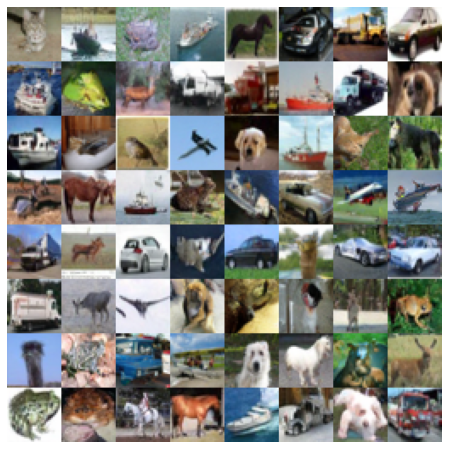

In [7]:
#@title PC sampling
random_seed = 0 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)
img_size = config.data.image_size
channels = config.data.num_channels
shape = (local_batch_size, img_size, img_size, channels)
predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = None #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  1#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = sampling.get_pc_sampler(sde, score_model, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps)


rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x, n = sampling_fn(step_rng, pstate)
show_samples(x, re_shift=False)

# Check ODE sampling

## One batch

In [14]:
random_seed = 0
rng = jax.random.PRNGKey(random_seed)

shape = (local_batch_size, 32, 32, 3)
ode_sampling_fn = sampling.get_ode_sampler(sde, 
                                       score_model, 
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps)
rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x, nfe = ode_sampling_fn(step_rng, pstate)

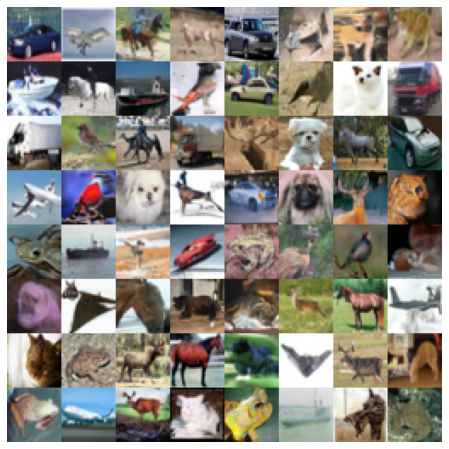

In [17]:
show_samples(x, re_shift=False)

## Check FIDs

In [18]:
import gc
import io
import evaluation
import tqdm

### Worker

In [23]:
def worker_fn(eval_dir, sampling_fn, rng, inceptionv3, inception_model,begin_sampling_round, num_sampling_rounds):
  for r in tqdm.tqdm(range(begin_sampling_round, num_sampling_rounds)):
    this_sample_dir = eval_dir
    tf.io.gfile.makedirs(this_sample_dir)

    rng, *sample_rng = jax.random.split(rng, jax.local_device_count() + 1)
    sample_rng = jnp.asarray(sample_rng)
    samples, cur_nfe = sampling_fn(sample_rng, pstate)
    samples = np.clip(samples * 255., 0, 255).astype(np.uint8)
    samples = samples.reshape(
      (-1, config.data.image_size, config.data.image_size, config.data.num_channels))
    # Write samples to disk or Google Cloud Storage
    with tf.io.gfile.GFile(
        os.path.join(this_sample_dir, f"samples_{r}.npz"), "wb") as fout:
      io_buffer = io.BytesIO()
      np.savez_compressed(io_buffer, samples=samples, nfe=cur_nfe)
      fout.write(io_buffer.getvalue())

    # Force garbage collection before calling TensorFlow code for Inception network
    gc.collect()
    latents = evaluation.run_inception_distributed(samples, inception_model,
                                                   inceptionv3=inceptionv3)
    # Force garbage collection again before returning to JAX code
    gc.collect()
    # Save latent represents of the Inception network to disk or Google Cloud Storage
    with tf.io.gfile.GFile(
        os.path.join(this_sample_dir, f"statistics_{r}.npz"), "wb") as fout:
      io_buffer = io.BytesIO()
      np.savez_compressed(
        io_buffer, pool_3=latents["pool_3"], logits=latents["logits"])
      fout.write(io_buffer.getvalue())

In [24]:
init_rng = random.PRNGKey(0)
# Use inceptionV3 for images with resolution higher than 256.
inceptionv3 = config.data.image_size >= 256
inception_model = evaluation.get_inception_model(inceptionv3=inceptionv3)

# change to a more namingful dir
worker_fn("logs/delete_me", ode_sampling_fn, init_rng, inceptionv3, inception_model,begin_sampling_round=0, num_sampling_rounds=config.eval.num_samples // config.eval.batch_size + 1)

  9%|▉         | 71/782 [09:25<1:34:21,  7.96s/it]


KeyboardInterrupt: 